In [2]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date
from matplotlib.colors import LogNorm
from matplotlib import cm
import matplotlib
from scipy import stats
import copy
from function import confid

import cartopy.crs as ccrs                   # import projections
import cartopy
import scipy.signal
from scipy.io import loadmat
import pyresample

/vortexfs1/home/wwu/.conda/envs/myenv/lib/python3.8/site-packages/pyresample/bilinear/__init__.py:50: UserWarning: XArray and/or zarr not found, XArrayBilinearResampler won't be available.
  warnings.warn("XArray and/or zarr not found, XArrayBilinearResampler won't be available.")


In [3]:
#loading data for fft of running avergaed filtered ssh

path = 'data/fft_ssh_hann_26_39_3x3_ave.nc'
#path='/vortexfs1/share/mahadevanlab/roger/h_su_sv_5day/fft_ssh_hann_26_39_3x3_ave.nc'
nc=Dataset(path,'r')
fft_h = nc.variables['fft_h_real'][:] \
       + 1j* nc.variables['fft_h_img'][:]
lon=nc.variables['lon'][:]
lon =360*(lon<0)+lon
lat=nc.variables['lat'][:]

lon2d,lat2d=np.meshgrid(lon,lat)
#the longitude of coherence reference location, default is 230.
#(the resolution of longitude and latitude is 0.1 deg)
ref_lon =230.0
#the latitude of coherence reference location, default is 5.4.
ref_lat =5.4
#find the location index of the nearest grid
dis = (lon2d-ref_lon)**2. + (lat2d-ref_lat)**2.
idx = np.nonzero(dis ==dis.min())

x0 = lon2d[int(idx[0]),int(idx[1])]
y0 = lat2d[int(idx[0]),int(idx[1])]

fft_ref = fft_h[:,int(idx[0]),int(idx[1])]
N=1022. # number of data points (use later to normalize fft output)
df=nc.variables['cycle_per_day'][1]- nc.variables['cycle_per_day'][0]
S_ref = np.mean(2.*(np.absolute(fft_ref)**2.)/(N**2. * df),axis = 0)

In [4]:
#loading data for fft of running avergaed global 5m U,V
# each file is half-globe


path='data/fft_u_hann_26_39_3x3_ave_1.nc'
#path='/vortexfs1/share/mahadevanlab/roger/PoP_global_5m_uv_h/fft_u_hann_26_39_3x3_ave_1.nc'
nc=Dataset(path,'r')
lat=nc.variables['lat'][:]
lon1=nc.variables['lon'][:]
fft_u1 = nc.variables['fft_su_real'][:] \
       + 1j* nc.variables['fft_su_img'][:]
nc.close()
path='data/fft_u_hann_26_39_3x3_ave_2.nc'
#path='/vortexfs1/share/mahadevanlab/roger/PoP_global_5m_uv_h/fft_u_hann_26_39_3x3_ave_2.nc'
nc=Dataset(path,'r')
lat=nc.variables['lat'][:]
lon2=nc.variables['lon'][:]
fft_u2 = nc.variables['fft_su_real'][:] \
       + 1j* nc.variables['fft_su_img'][:]
nc.close()
fft_u=np.ma.append(fft_u1,fft_u2,axis=2)
lon=np.ma.append(lon1,lon2)

path='data/fft_v_hann_26_39_3x3_ave_1.nc'
#path='/vortexfs1/share/mahadevanlab/roger/PoP_global_5m_uv_h/fft_v_hann_26_39_3x3_ave_1.nc'
nc=Dataset(path,'r')
fft_v1 = nc.variables['fft_sv_real'][:] \
       + 1j* nc.variables['fft_sv_img'][:]
nc.close()
path='data/fft_v_hann_26_39_3x3_ave_2.nc'
#path='/vortexfs1/share/mahadevanlab/roger/PoP_global_5m_uv_h/fft_v_hann_26_39_3x3_ave_2.nc'
nc=Dataset(path,'r')
fft_v2 = nc.variables['fft_sv_real'][:] \
       + 1j* nc.variables['fft_sv_img'][:]
nc.close()
fft_v=np.ma.append(fft_v1,fft_v2,axis=2)

In [5]:
S_u = np.mean(2.* (np.absolute(fft_u)**2.)/(N**2. * df),axis = 0)
S_v = np.mean(2.* (np.absolute(fft_v)**2.)/(N**2. * df),axis = 0)

cp = fft_u*np.conjugate(fft_ref)[...,np.newaxis,np.newaxis]
C_lf = np.mean(2.*cp/(N**2. * df),axis = 0)
coh_u = np.absolute(C_lf)**2./(S_u*S_ref)

cp = fft_v*np.conjugate(fft_ref)[...,np.newaxis,np.newaxis]
C_lf = np.mean(2.*cp/(N**2. * df),axis = 0)
coh_v = np.absolute(C_lf)**2./(S_v*S_ref)

frac = (coh_u*S_u + coh_v*S_v)/ (S_u + S_v)
#effective degree of number given 10 neighboring frequencies and using hann
#window
n_eff=10./1.9445

#significance level for coherence
errbar = np.sqrt(1.-(0.05)**(1./( n_eff -1))) 

frac_bar = (errbar**2.*S_u + errbar**2.*S_v)/ (S_u + S_v)

<ipython-input-7-49b96615511e>:4: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("turbo"))
  current_cmap.set_bad(color='0.6')


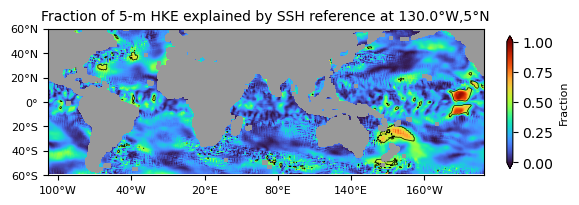

In [7]:
plt.figure(dpi=100)
degree_sign= u'\N{DEGREE SIGN}'
current_cmap = plt.get_cmap('turbo')
current_cmap.set_bad(color='0.6')
cs = plt.pcolormesh(np.arange(0,356.8,0.1),lat,frac,shading = 'nearest',\
              vmin=0,vmax=1.,cmap=current_cmap)
plt.axis('scaled')
cb = plt.colorbar(cs,extend='both',fraction = 0.013)
cb.set_label('Fraction',fontsize = 8)

plt.contour(np.arange(0,356.8,0.1),lat,frac,[errbar**2.],colors= 'k',linewidths = 0.5)

plt.xticks([np.arange(0,356.8,0.1)[98-15],\
            np.arange(0,356.8,0.1)[98-15+600],\
            np.arange(0,356.8,0.1)[98-15+2*600],\
            np.arange(0,356.8,0.1)[98-15+3*600],\
           np.arange(0,356.8,0.1)[98-15+4*600],\
           np.arange(0,356.8,0.1)[98-15+5*600]],\
           ['100'+degree_sign+'W',\
            '40'+degree_sign+'W',\
           '20'+degree_sign+'E',\
           '80'+degree_sign+'E',\
           '140'+degree_sign+'E',\
           '160'+degree_sign+'W'],fontsize = 8)
plt.yticks([-60,-40,-20,0,20,40,60],['60'+degree_sign+'S','40'+degree_sign+'S','20'+degree_sign+'S','0'+degree_sign, '20'+degree_sign+'N', '40'+degree_sign+'N', '60'+degree_sign+'N'],fontsize = 8)
plt.title('Fraction of 5-m HKE explained by SSH reference at '+\
          str(round(360-x0,1))+degree_sign+'W,'+str(int(y0))+degree_sign+'N',size =10.)

#plt.savefig('/vortexfs1/scratch/wwu/rossby_wave_python_code/figures/EKE_frac_3deg_ave.png',dpi = 300,bbox_inches='tight', pad_inches=0)

plt.show()